######################################################################################################
# STAGE 2 - Analysis for 2 classes, title+content only
######################################################################################################
# WITH RANDOM OVERSAMPLER
######################################################################################################

In [ ]:
# HOW TO IMPROVE MODELS?

### 1: (done in Notebook "Elisa_Report2_Modeling_Stage2")
# # try to improve prediction for left bottom corner (false negatives)
# PARAMETER TUNING (e.g. num_boost_rounds)
# --> improves results a lot


### 2: (done in Notebook "Elisa_Report2_Modeling_Stage2")
# use class_weights
# class 1: weight it 1,38 times
# done for logistic regression, passive aggressive classifier, SGD, LightGBM

# LogReg, PassiveAggressive, SGD: as attributes (class_weight=class_weights)

# LightGBM: in params 

# --> does not really improve results 
# --> test whether it changes in combination wih oversampling 



### 3: DONE IN THIS NOTEBOOK
# --> using OverSample to deal with slightly unbalanced dataset
# Random Oversampling (RandomOverSampler) and SMOTE (SMOTE)
# not much of an improvement


### 4: done in Notebook "Elisa_Report2_Modeling_Stage3"
# Cross Validation (Stage 3)


### 5: done in Notebook "Elisa_Report2_Modeling_Stage3"
# compare different vectorizing methods

In [ ]:

##########################
## STAGE 2 - Analysis for 2 classes, title+content only
##########################

## We kept only two labels for further classification modeling:
# 0: articles from reliable sources
# 1: articles from unreliable sources

# USED PRE-PROCESSED DATASET: strats12_all_cleaned.pkl
# LOAD AS DF12
# --> contains 126.335 rows after pre-processing (2 classes)

# 0.0    73271
# 1.0    53084


#########
# Pre-Processing Steps:
# delete label "2: mixed"
# Create dataframe with title+content variables only
# remove stop words
# vectorize text (TF-IDF)
#########



# We only used title + content (vectorized)
# trial of boosting and 3 more complex models


# MODELS FOR STAGE 2 (Advanced Models):
# 1) Naive Bayes Bernoulli
# 2) Naive Bayes Multinomial
# 3) Naive Bayes Complement
# 4) Logistic Regression****

# 5) Random Forest   --> takes very long! 
# 6) Passive Aggressive Classifier****

# 7) LightGBM
# 8) CatBoost
# 9) XGBoost

# 10) Stochastic Gradient Descent (SGD)****

# ****: very good results


# Import libraries

In [3]:
import numpy as np
import pandas as pd
from matplotlib.pylab import plt
import seaborn as sns
# from sqlalchemy import create_engine
# import sqlalchemy as 
import sqlite3
import nltk
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import RandomOverSampler, SMOTE


# Load dataset + Pre-Processing

In [4]:
df12 = pd.read_pickle("strats12_all_cleaned.pkl")

In [5]:
df12.head(2)

,id,source,title,content,url,published_utc,label,factuality,questionable-source,conspiracy-pseudoscience,pro-science
0,21stcenturywire--2022-04-26--An Unsettling Rea...,21stcenturywire,An Unsettling Realization: ‘Mask Zealots are S...,It’s been noted how the fanatical nature of ma...,https://21stcenturywire.com/2022/04/26/an-unse...,1650983484,1.0,2.0,0.0,1.0,0.0
1,21stcenturywire--2022-04-24--Episode #416 – ‘S...,21stcenturywire,Episode #416 – ‘Soldiers of Fortune’ with gues...,Episode #416 of SUNDAY WIRE SHOW resumes this ...,https://21stcenturywire.com/2022/04/24/episode...,1650823248,1.0,2.0,0.0,1.0,0.0


In [6]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170099 entries, 0 to 213392
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        170099 non-null  object 
 1   source                    170099 non-null  object 
 2   title                     170099 non-null  object 
 3   content                   170099 non-null  object 
 4   url                       170099 non-null  object 
 5   published_utc             170099 non-null  int64  
 6   label                     170099 non-null  float64
 7   factuality                170099 non-null  float64
 8   questionable-source       170099 non-null  float64
 9   conspiracy-pseudoscience  170099 non-null  float64
 10  pro-science               170099 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 15.6+ MB


In [7]:
# inspect labels
df12["label"].value_counts()

# slightly unbalanced


0.0    73271
1.0    53084
2.0    43744
Name: label, dtype: int64

In [8]:
### DELETE 2 in labels (delete 43744 rows)
df12 = df12[df12["label"] != 2]


In [9]:
# inspect labels
df12["label"].value_counts()

# 0.0    73271
# 1.0    53084

0.0    73271
1.0    53084
Name: label, dtype: int64

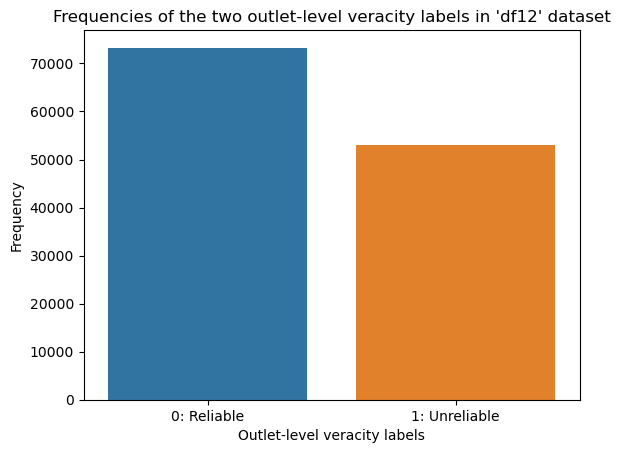

In [10]:
# barplot of labels
sns.countplot(x = "label", data = df12)
plt.xticks(np.arange(2),["0: Reliable", "1: Unreliable"])
plt.ylabel("Frequency")
plt.xlabel("Outlet-level veracity labels")
plt.title("Frequencies of the two outlet-level veracity labels in 'df12' dataset")
plt.show();


In [11]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126355 entries, 0 to 213392
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        126355 non-null  object 
 1   source                    126355 non-null  object 
 2   title                     126355 non-null  object 
 3   content                   126355 non-null  object 
 4   url                       126355 non-null  object 
 5   published_utc             126355 non-null  int64  
 6   label                     126355 non-null  float64
 7   factuality                126355 non-null  float64
 8   questionable-source       126355 non-null  float64
 9   conspiracy-pseudoscience  126355 non-null  float64
 10  pro-science               126355 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 11.6+ MB


# Remove Stop Words 

In [12]:
import nltk
from nltk.corpus import stopwords

# Download stopwords corpus if not already downloaded
nltk.download('stopwords')

# Load the stopwords
stop_words = set(stopwords.words('english'))  # You can choose a different language if needed

# Update stop words variable
# stop_words.update([",", "."])

additional_words = ["?", "!", ".", ",", ":", ";", "-", "--", "...", '"', "'"]
stop_words.update(set(additional_words))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nutzer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# show stop words
print(stop_words)


{'why', 't', 'hadn', ',', 'there', 'ourselves', "needn't", 'shouldn', 'wouldn', 'at', 'had', "should've", 'from', 'that', 'can', 'am', 'won', 'into', 'now', "hadn't", 'until', 'no', "you're", 'if', 'out', 'each', 're', "haven't", 'herself', 's', 'didn', 'me', "doesn't", 'against', 'for', 'is', 'a', "hasn't", 'y', 'just', "didn't", '--', 'yours', 'once', 'i', "aren't", "it's", 'these', 'being', 'then', ';', 'about', 'whom', '!', 'mightn', 'he', 'because', 'an', 'ours', 'does', 'we', 'off', "that'll", 'nor', 'own', "weren't", 'll', 'doesn', 'has', 'you', 'any', '"', "don't", "wasn't", 'be', 'doing', 'same', '.', 'she', 'more', "mustn't", 'before', 'have', 'only', 'with', 'itself', 'do', 'which', 'themselves', 'between', 'the', 'its', 'haven', "you'd", 'shan', "you'll", 'ma', 'after', 'needn', 'than', "couldn't", '?', "wouldn't", '...', 'on', 'who', 'while', 'to', 'having', 'too', 'some', 'my', 'what', 'not', ':', 'further', 'were', 'himself', 'here', 'by', 'most', 'over', 'again', 'your'

In [14]:
# content before removing stop words
df12["content"][:10]


0    It’s been noted how the fanatical nature of ma...
1    Episode #416 of SUNDAY WIRE SHOW resumes this ...
2    Authoritarians in the UK government are gettin...
3    After the 2020 election, many Americans began ...
4    The high stakes game surrounding the Ukraine c...
5    On the February 3, 2022 episode of Patrick Hen...
6    These are the darkest, most difficult days in ...
7    A shocking new trend is on the move in America...
8    In this episode of the Patrick Henningsen Show...
9    Liz Cheney invokes Ronald Reagan to bash those...
Name: content, dtype: object

In [15]:
# Apply
df12['content_cleaned'] = df12['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))


In [16]:
df12["content_cleaned"][:10]


0    It’s noted fanatical nature masking proponents...
1    Episode #416 SUNDAY WIRE SHOW resumes week, Ap...
2    Authoritarians UK government getting increasin...
3    2020 election, many Americans began question m...
4    high stakes game surrounding Ukraine conflict ...
5    February 3, 2022 episode Patrick Henningsen Sh...
6    darkest, difficult days human history. facing ...
7    shocking new trend move America: following his...
8    episode Patrick Henningsen Show TNT Radio aire...
9    Liz Cheney invokes Ronald Reagan bash GOP want...
Name: content_cleaned, dtype: object

# Title + Content Data from df12 dataset

# Create X and Y (only title and text)
# X_train_text_df12_tfidf, 
# X_test_text_df12_tfidf, 
# Y_train_df12, 
# Y_test_df12 (uppercase letters)


In [17]:
# DEFINE X and Y
X_df12 = df12.drop("label", axis=1)
Y_df12 = df12["label"]


In [18]:
X_df12.columns = X_df12.columns.astype(str)

In [19]:
X_df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126355 entries, 0 to 213392
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        126355 non-null  object 
 1   source                    126355 non-null  object 
 2   title                     126355 non-null  object 
 3   content                   126355 non-null  object 
 4   url                       126355 non-null  object 
 5   published_utc             126355 non-null  int64  
 6   factuality                126355 non-null  float64
 7   questionable-source       126355 non-null  float64
 8   conspiracy-pseudoscience  126355 non-null  float64
 9   pro-science               126355 non-null  float64
 10  content_cleaned           126355 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 11.6+ MB


In [20]:
X_df12.isnull().sum()

id                          0
source                      0
title                       0
content                     0
url                         0
published_utc               0
factuality                  0
questionable-source         0
conspiracy-pseudoscience    0
pro-science                 0
content_cleaned             0
dtype: int64

In [21]:
Y_df12.info()

<class 'pandas.core.series.Series'>
Int64Index: 126355 entries, 0 to 213392
Series name: label
Non-Null Count   Dtype  
--------------   -----  
126355 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [22]:
Y_df12.isnull().sum()

0

## Create Train / Test Datasets

In [23]:
from sklearn.model_selection import train_test_split

X_train_df12, X_test_df12, Y_train_df12, Y_test_df12 = train_test_split(X_df12, Y_df12, test_size=0.2)


# Vectorizing

### TFIDF Vectorizing
### USING CONTENT_CLEANED AND TITLE ONLY


In [24]:
# VECTORIZING
# TAKES 2 MINUTES

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

vectorizer1_df12_tfidf = TfidfVectorizer()
vectorizer2_df12_tfidf = TfidfVectorizer()

vectorizer1_df12_tfidf.fit(X_train_df12['content_cleaned'])
vectorizer2_df12_tfidf.fit(X_train_df12['title'])


TfidfVectorizer()

In [25]:
# TAKES 2 MINUTES

X_train_content_df12_tfidf = vectorizer1_df12_tfidf.transform(X_train_df12['content_cleaned'])
X_train_title_df12_tfidf = vectorizer2_df12_tfidf.transform(X_train_df12['title'])
X_test_content_df12_tfidf = vectorizer1_df12_tfidf.transform(X_test_df12['content_cleaned'])
X_test_title_df12_tfidf = vectorizer2_df12_tfidf.transform(X_test_df12['title'])


In [27]:
X_train_text_df12_tfidf = hstack([X_train_content_df12_tfidf, X_train_title_df12_tfidf])
X_test_text_df12_tfidf = hstack([X_test_content_df12_tfidf, X_test_title_df12_tfidf])


In [28]:
X_train_text_df12_tfidf

<101084x338505 sparse matrix of type '<class 'numpy.float64'>'
	with 21390669 stored elements in Compressed Sparse Row format>

In [29]:
X_train_text_df12_tfidf.shape

(101084, 338505)

In [30]:
X_test_text_df12_tfidf

<25271x338505 sparse matrix of type '<class 'numpy.float64'>'
	with 5332579 stored elements in Compressed Sparse Row format>

In [31]:
X_test_text_df12_tfidf.shape

(25271, 338505)

In [32]:
Y_train_df12

12684     1.0
101668    0.0
200947    0.0
22377     0.0
54264     0.0
         ... 
166886    0.0
41730     0.0
64547     1.0
15530     1.0
96635     0.0
Name: label, Length: 101084, dtype: float64

In [33]:
Y_test_df12

115528    1.0
90516     1.0
120930    1.0
71452     1.0
192902    0.0
         ... 
11911     1.0
19670     0.0
21769     0.0
22750     0.0
54930     0.0
Name: label, Length: 25271, dtype: float64

In [ ]:
## MODELS FOR STAGE 2 (Advanced Models):
# 1) Naive Bayes Bernoulli
# 2) Naive Bayes Multinomial
# 3) Naive Bayes Complement
# 4) Logistic Regression
# 5) Random Forest

# 6) Passive Aggressive Classifier 
# 7) Stochastic Gradient Descent (SGD)

# 8) LightGBM
# 9) CatBoost
# 10) XGBoost


# Oversampling

In [34]:
# Random Over Sampler
rOs = RandomOverSampler()

X_ro, y_ro = rOs.fit_resample(X_train_text_df12_tfidf, Y_train_df12)

print("Number of elements of each class if the new rOs set:", dict(pd.Series(y_ro).value_counts()))



Number of elements of each class if the new rOs set: {1.0: 58712, 0.0: 58712}


In [ ]:
# SMOTE
# smo = SMOTE()

# X_sm, y_sm = smo.fit_resample(X_train_text_df12_tfidf, Y_train_df12)

# print("Number of elements of each class if the new smo set:", dict(pd.Series(y_sm).value_counts()))


# 1 Naive Bayes Bernoulli on text data df12 

In [35]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [36]:
# Create a Bernoulli Naive Bayes classifier
clf_Bern_df12_tfidf = BernoulliNB()


In [37]:
# Train the classifier
clf_Bern_df12_tfidf.fit(X_ro, y_ro)


BernoulliNB()

In [38]:
# Make predictions on the test set
y_pred_NB_Bern_df12_tfidf = clf_Bern_df12_tfidf.predict(X_test_text_df12_tfidf)


In [39]:
# Evaluate the model with accuracy
accuracy_NB_Bern_df12_tfidf = accuracy_score(Y_test_df12, y_pred_NB_Bern_df12_tfidf)
print("Accuracy:", accuracy_NB_Bern_df12_tfidf)

# 0.72
# no change

Accuracy: 0.7197973962249219


In [40]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_NB_Bern_df12_tfidf = f1_score(Y_test_df12, y_pred_NB_Bern_df12_tfidf)
f1_NB_Bern_df12_tfidf

# 0.7079
# slight improvement

0.7079156870024337

In [41]:
# Evaluate Model with confusion matrix 
from sklearn.metrics import confusion_matrix 

cf_matrix_NB_Bern_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_NB_Bern_df12_tfidf)
print("Confusion Matrix:\n",  cf_matrix_NB_Bern_df12_tfidf)

# overall prediction is ok but not very good for any case

Confusion Matrix:
 [[9609 4950]
 [2131 8581]]


In [42]:
# Evaluate model with classification report
from sklearn.metrics import classification_report 

print("Naive Bayes Bernoulli df12 tfidf classification report:\n", classification_report (Y_test_df12, y_pred_NB_Bern_df12_tfidf))


Naive Bayes Bernoulli df12 tfidf classification report:
               precision    recall  f1-score   support

         0.0       0.82      0.66      0.73     14559
         1.0       0.63      0.80      0.71     10712

    accuracy                           0.72     25271
   macro avg       0.73      0.73      0.72     25271
weighted avg       0.74      0.72      0.72     25271



# 2 MULTINOMIAL NAIVE BAYES on text data df12


In [43]:
from sklearn.naive_bayes import MultinomialNB

In [44]:
from sklearn.naive_bayes import MultinomialNB
clf_mult_df12_tfidf = MultinomialNB()


In [45]:
# fit the model
clf_mult_df12_tfidf.fit(X_ro, y_ro)


MultinomialNB()

In [46]:
y_pred_NB_Mult_df12_tfidf = clf_mult_df12_tfidf.predict(X_test_text_df12_tfidf)


In [47]:
# get accuracy
accuracy_NB_Mult_df12_tfidf = clf_mult_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_NB_Mult_df12_tfidf

# 0.79
# slight improvement

0.7934786909896719

In [48]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_NB_Mult_df12_tfidf = f1_score(Y_test_df12, y_pred_NB_Mult_df12_tfidf)
f1_NB_Mult_df12_tfidf

# 0.757
# improvement

0.7571993486857409

In [49]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_NB_Mult_df12_tfidf, rownames=["true"], colnames=["predict"])

# overall prediction is ok
# best prediction: real news as real news (0:0)

predict,0.0,1.0
true,,
0.0,11914,2645
1.0,2574,8138


In [50]:
from sklearn.metrics import classification_report 

# get classification report
print("Naive Bayes Multinomial df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_NB_Mult_df12_tfidf))

Naive Bayes Multinomial df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.82      0.82      0.82     14559
         1.0       0.75      0.76      0.76     10712

    accuracy                           0.79     25271
   macro avg       0.79      0.79      0.79     25271
weighted avg       0.79      0.79      0.79     25271



In [51]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


In [52]:
# create confusion matrix
cf_matrix_NB_Mult_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_NB_Mult_df12_tfidf)
print(cf_matrix_NB_Mult_df12_tfidf)


[[11914  2645]
 [ 2574  8138]]


# 3 COMPLEMENT NAIVE BAYES on text data df12


In [53]:
from sklearn.naive_bayes import ComplementNB
clf_compl_df12_tfidf = ComplementNB()


In [54]:
# fit model
clf_compl_df12_tfidf.fit(X_ro, y_ro)


ComplementNB()

In [55]:
y_pred_NB_Compl_df12_tfidf = clf_compl_df12_tfidf.predict(X_test_text_df12_tfidf)


In [56]:
# get accuracy
accuracy_NB_Compl_df12_tfidf = clf_compl_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_NB_Compl_df12_tfidf

# 0.79
# no change

0.7934786909896719

In [57]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_NB_Compl_df12_tfidf = f1_score(Y_test_df12, y_pred_NB_Compl_df12_tfidf)
f1_NB_Compl_df12_tfidf

# 0.757
# improvement

0.7571993486857409

In [58]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_NB_Compl_df12_tfidf, rownames=["true"], colnames=["predict"])

# overall prediction is ok
# best prediction: real news as real news (0:0)

predict,0.0,1.0
true,,
0.0,11914,2645
1.0,2574,8138


In [59]:
from sklearn.metrics import classification_report 

# get classification report
print("Naive Bayes Complement df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_NB_Compl_df12_tfidf))


Naive Bayes Complement df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.82      0.82      0.82     14559
         1.0       0.75      0.76      0.76     10712

    accuracy                           0.79     25271
   macro avg       0.79      0.79      0.79     25271
weighted avg       0.79      0.79      0.79     25271



In [60]:
# create confusion matrix
cf_matrix_Compl_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_NB_Compl_df12_tfidf)
print(cf_matrix_Compl_df12_tfidf)


[[11914  2645]
 [ 2574  8138]]


# 4a CREATE LOGISTIC REGRESSION MODEL ON TEXT DATA df12


In [61]:
# Step 3: Instantiate model 
from sklearn.linear_model import LogisticRegression

clf_LogReg_df12_tfidf = LogisticRegression(C=1.0)
# clf_LogReg_df12_tfidf = LogisticRegression(C=1.0, class_wight="balanced")
# clf_LogReg_df12_tfidf = LogisticRegression(C=1.0, penalty="elasticnet")


In [62]:
# Step 4: Fit the model on the training dataset
clf_LogReg_df12_tfidf.fit(X_ro, y_ro)


C:\Users\Nutzer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [63]:
y_pred_LogReg_df12_tfidf = clf_LogReg_df12_tfidf.predict(X_test_text_df12_tfidf)


In [64]:
# get accuracy
accuracy_LogReg_df12_tfidf = clf_LogReg_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_LogReg_df12_tfidf

# 0.8557
# slightly worse

0.8557635234062759

In [65]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_LogReg_df12_tfidf = f1_score(Y_test_df12, y_pred_LogReg_df12_tfidf)
f1_LogReg_df12_tfidf

# 0.83
# slight improvement

0.8318804483188044

In [66]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LogReg_df12_tfidf, rownames=["true"], colnames=["predict"])

# overall prediction is quite good
# best prediction: real news as real news (0:0), followed by fake news as fake news (1:1)

predict,0.0,1.0
true,,
0.0,12608,1951
1.0,1694,9018


In [67]:
from sklearn.metrics import classification_report 

# get classification report
print("Logistic Regression df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_LogReg_df12_tfidf))


Logistic Regression df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.88      0.87      0.87     14559
         1.0       0.82      0.84      0.83     10712

    accuracy                           0.86     25271
   macro avg       0.85      0.85      0.85     25271
weighted avg       0.86      0.86      0.86     25271



In [68]:
# create confusion matrix
cf_matrix_LogReg_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_LogReg_df12_tfidf)
print(cf_matrix_LogReg_df12_tfidf)


[[12608  1951]
 [ 1694  9018]]


# 4b CREATE LOGISTIC REGRESSION MODEL ON TEXT DATA df12 with class_weights


In [69]:
# Definiere die gewünschten Klassengewichte
class_weights = {0: 1.0, 1: 1.38}  # Beispielwerte, die angepasst werden können


In [70]:
# Step 3: Instantiate model 
from sklearn.linear_model import LogisticRegression

clf_LogReg_df12_tfidf_CW = LogisticRegression(C=1.0, class_weight = class_weights)


In [71]:
# Step 4: Fit the model on the training dataset
clf_LogReg_df12_tfidf_CW.fit(X_ro, y_ro)


C:\Users\Nutzer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 1.0, 1: 1.38})

In [72]:
y_pred_LogReg_df12_tfidf_CW = clf_LogReg_df12_tfidf_CW.predict(X_test_text_df12_tfidf)


In [73]:
# get accuracy
accuracy_LogReg_df12_tfidf_CW = clf_LogReg_df12_tfidf_CW.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_LogReg_df12_tfidf_CW

# 0.848
# slightly worse

0.8484824502394048

In [74]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_LogReg_df12_tfidf_CW = f1_score(Y_test_df12, y_pred_LogReg_df12_tfidf_CW)
f1_LogReg_df12_tfidf_CW

# 0.83
# no change

0.8299053795921993

In [75]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LogReg_df12_tfidf_CW, rownames=["true"], colnames=["predict"])

# overall prediction is quite good
# best prediction: real news as real news (0:0), followed by fake news as fake news (1:1)
# lowest value for false negatives

predict,0.0,1.0
true,,
0.0,12101,2458
1.0,1371,9341


In [76]:
from sklearn.metrics import classification_report 

# get classification report
print("Logistic Regression df12 tfidf with class weights classification report:\n ", classification_report (Y_test_df12, y_pred_LogReg_df12_tfidf_CW))


Logistic Regression df12 tfidf with class weights classification report:
                precision    recall  f1-score   support

         0.0       0.90      0.83      0.86     14559
         1.0       0.79      0.87      0.83     10712

    accuracy                           0.85     25271
   macro avg       0.84      0.85      0.85     25271
weighted avg       0.85      0.85      0.85     25271



In [77]:
# create confusion matrix
cf_matrix_LogReg_df12_tfidf_CW = confusion_matrix(Y_test_df12, y_pred_LogReg_df12_tfidf_CW)
print(cf_matrix_LogReg_df12_tfidf_CW)


[[12101  2458]
 [ 1371  9341]]


# 5 RANDOM FOREST on text data df12
# takes too long

In [125]:
# from sklearn.ensemble import RandomForestClassifier

In [126]:
# Instantiate the model
# clf_rf_df12_tfidf = RandomForestClassifier()


In [127]:
# fit model
# clf_rf_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)


RandomForestClassifier()

In [128]:
#Predict on the test set 
# y_pred_rf_df12_tfidf = clf_rf_df12_tfidf.predict(X_test_text_df12_tfidf)


In [129]:
# get accuracy
# accuracy_rf_df12_tfidf = clf_rf_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
# accuracy_rf_df12_tfidf

# 0.788


0.7886510229116378

In [130]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

# f1_rf_df12_tfidf = f1_score(Y_test_df12, y_pred_rf_df12_tfidf)
# f1_rf_df12_tfidf

# 0.6876


0.687642552196035

In [131]:
# get confusion matrix
# pd.crosstab(Y_test_df12, y_pred_rf_df12_tfidf, rownames=["true"], colnames=["predict"])

# perfect for fake news

# overall prediction is quite good
# best prediction: real news as real news (0:0), followed by fake news as fake news (1:1)
# best result for false positives (real news being predicted as fake news)

predict,0.0,1.0
true,,
0.0,14051,557
1.0,4784,5879


In [132]:
# from sklearn.metrics import classification_report 

# get classification report
# print("Random Forest df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_rf_df12_tfidf))


Random Forest df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.75      0.96      0.84     14608
         1.0       0.91      0.55      0.69     10663

    accuracy                           0.79     25271
   macro avg       0.83      0.76      0.76     25271
weighted avg       0.82      0.79      0.78     25271



In [133]:
# create confusion matrix
# cf_matrix_rf_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_rf_df12_tfidf)
# print(cf_matrix_rf_df12_tfidf)


[[14051   557]
 [ 4784  5879]]


# 6a Passive Aggressive Classifier on text data df12


Passive Aggressive Classifier Passive Aggressive algorithms are online learning algorithms. Such an algorithm remains passive for a correct classification outcome, and turns aggressive in the event of a miscalculation, updating and adjusting. Unlike most other algorithms, it does not converge. Its purpose is to make updates that correct the loss, causing very little change in the norm of the weight vector.


In [81]:
from sklearn.linear_model import PassiveAggressiveClassifier


In [84]:
# Initialize a PassiveAggressiveClassifier
pac_df12_tfidf = PassiveAggressiveClassifier(max_iter=50)


In [85]:
# fit model
pac_df12_tfidf.fit(X_ro, y_ro)


PassiveAggressiveClassifier(max_iter=50)

In [86]:
#Predict on the test set 
y_pred_PassAgg_df12_tfidf = pac_df12_tfidf.predict(X_test_text_df12_tfidf)


In [87]:
# get accuracy
accuracy_PassAgg_df12_tfidf= pac_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_PassAgg_df12_tfidf

# 0.82
# no change

0.8211784258636382

In [88]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_PassAgg_df12_tfidf = f1_score(Y_test_df12, y_pred_PassAgg_df12_tfidf)
f1_PassAgg_df12_tfidf

# 0.789
# slight improvement

0.7894516144061875

In [89]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_PassAgg_df12_tfidf, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no very good prediction for any case

predict,0.0,1.0
true,,
0.0,12280,2279
1.0,2240,8472


In [90]:
from sklearn.metrics import classification_report 

# get classification report
print("Passive Aggressive df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_PassAgg_df12_tfidf))


Passive Aggressive df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.85      0.84      0.84     14559
         1.0       0.79      0.79      0.79     10712

    accuracy                           0.82     25271
   macro avg       0.82      0.82      0.82     25271
weighted avg       0.82      0.82      0.82     25271



In [91]:
# create confusion matrix
cf_matrix_PassAgg_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_PassAgg_df12_tfidf)
print(cf_matrix_PassAgg_df12_tfidf)


[[12280  2279]
 [ 2240  8472]]


# 6b Passive Aggressive Classifier on text data df12 with class weights


Passive Aggressive Classifier Passive Aggressive algorithms are online learning algorithms. Such an algorithm remains passive for a correct classification outcome, and turns aggressive in the event of a miscalculation, updating and adjusting. Unlike most other algorithms, it does not converge. Its purpose is to make updates that correct the loss, causing very little change in the norm of the weight vector.


In [92]:
from sklearn.linear_model import PassiveAggressiveClassifier


In [93]:
# Definiere die gewünschten Klassengewichte
class_weights = {0: 1.0, 1: 1.38}  # Beispielwerte, die angepasst werden können


In [94]:
# Initialize a PassiveAggressiveClassifier
pac_df12_tfidf_CW = PassiveAggressiveClassifier(max_iter=50, class_weight=class_weights)


In [95]:
# fit model
pac_df12_tfidf_CW.fit(X_ro, y_ro)


PassiveAggressiveClassifier(class_weight={0: 1.0, 1: 1.38}, max_iter=50)

In [96]:
#Predict on the test set 
y_pred_PassAgg_df12_tfidf_CW = pac_df12_tfidf_CW.predict(X_test_text_df12_tfidf)


In [97]:
# get accuracy
accuracy_PassAgg_df12_tfidf_CW = pac_df12_tfidf_CW.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_PassAgg_df12_tfidf_CW

# 0.82
# no change


0.8198725812195797

In [98]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_PassAgg_df12_tfidf_CW = f1_score(Y_test_df12, y_pred_PassAgg_df12_tfidf_CW)
f1_PassAgg_df12_tfidf_CW

# 0.787
# no change

0.7878448918717375

In [99]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_PassAgg_df12_tfidf_CW, rownames=["true"], colnames=["predict"])

# overall prediction is quite good, similar to prediction without class_weights

predict,0.0,1.0
true,,
0.0,12267,2292
1.0,2260,8452


In [100]:
from sklearn.metrics import classification_report 

# get classification report
print("Passive Aggressive df12 tfidf with class weights classification report:\n ", classification_report (Y_test_df12, y_pred_PassAgg_df12_tfidf_CW))


Passive Aggressive df12 tfidf with class weights classification report:
                precision    recall  f1-score   support

         0.0       0.84      0.84      0.84     14559
         1.0       0.79      0.79      0.79     10712

    accuracy                           0.82     25271
   macro avg       0.82      0.82      0.82     25271
weighted avg       0.82      0.82      0.82     25271



In [101]:
# create confusion matrix
cf_matrix_PassAgg_df12_tfidf_CW = confusion_matrix(Y_test_df12, y_pred_PassAgg_df12_tfidf_CW)
print(cf_matrix_PassAgg_df12_tfidf_CW)


[[12267  2292]
 [ 2260  8452]]


# 7a LightGBM on text data df12 - 20 rounds

In [181]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [182]:
# Create a LightGBM dataset for training

LightGMB_train_data_text_df12_tfidf = lgb.Dataset(X_ro, label=y_ro)

# Set the hyperparameters for the LightGBM model
paramsLightGBM_df12_tfidf = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  # Set the appropriate objective for your classification task
    'metric': 'binary_logloss',  # Set the appropriate metric for evaluation
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


In [183]:
# Train the LightGBM model
clf_LightGBM_df12_tfidf = lgb.train(paramsLightGBM_df12_tfidf, LightGMB_train_data_text_df12_tfidf, num_boost_round=20)

# takes 3 minutes


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 25.214561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [184]:
# Make predictions on the test set
y_pred_LightGBM_df12_tfidf = clf_LightGBM_df12_tfidf.predict(X_test_text_df12_tfidf)
y_pred_LightGBM_df12_tfidf_binary = [round(pred) for pred in y_pred_LightGBM_df12_tfidf]  # Convert probability to binary predictions


In [185]:
# Evaluate the model with accuracy
accuracy_LightGBM_df12_tfidf = accuracy_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_binary)
print("Accuracy LightGBM vect:", accuracy_LightGBM_df12_tfidf)

# 0.75
# no change


Accuracy LightGBM vect: 0.7505441019350243


In [108]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_LightGBM_df12_tfidf = f1_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_binary)
f1_LightGBM_df12_tfidf

# 0.71
# improvement


0.7142339075249321

In [109]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LightGBM_df12_tfidf_binary, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0,1
true,,
0.0,11089,3470
1.0,2834,7878


In [112]:
# Evaluate Model with confusion matrix 
from sklearn.metrics import confusion_matrix 

cf_matrix_LightGBM_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_LightGBM_df12_tfidf_binary)

print("Confusion Matrix:\n",  cf_matrix_LightGBM_df12_tfidf)


Confusion Matrix:
 [[11089  3470]
 [ 2834  7878]]


In [113]:
# STEP 9: Evaluate model with classification report
from sklearn.metrics import classification_report 

print("LightGBM df12 tfidf classification report:\n", classification_report (Y_test_df12, y_pred_LightGBM_df12_tfidf_binary))


LightGBM df12 tfidf classification report:
               precision    recall  f1-score   support

         0.0       0.80      0.76      0.78     14559
         1.0       0.69      0.74      0.71     10712

    accuracy                           0.75     25271
   macro avg       0.75      0.75      0.75     25271
weighted avg       0.75      0.75      0.75     25271



# 7b LightGBM on text data df12 - 200 rounds

In [114]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [115]:
# Create a LightGBM dataset for training

LightGMB_train_data_text_df12_tfidf = lgb.Dataset(X_ro, label=y_ro)

# Set the hyperparameters for the LightGBM model
paramsLightGBM_df12_tfidf = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  # Set the appropriate objective for your classification task
    'metric': 'binary_logloss',  # Set the appropriate metric for evaluation
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


In [116]:
# Train the LightGBM model
clf_LightGBM_df12_tfidf_200 = lgb.train(paramsLightGBM_df12_tfidf, LightGMB_train_data_text_df12_tfidf, num_boost_round=200)

# takes 8 minutes


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 25.975366 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [117]:
# Make predictions on the test set
y_pred_LightGBM_df12_tfidf_200 = clf_LightGBM_df12_tfidf_200.predict(X_test_text_df12_tfidf)
y_pred_LightGBM_df12_tfidf_200_binary = [round(pred) for pred in y_pred_LightGBM_df12_tfidf_200]  
# Convert probability to binary predictions


In [118]:
# Evaluate the model with accuracy
accuracy_LightGBM_df12_tfidf_200 = accuracy_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_200_binary)
print("Accuracy LightGBM vect:", accuracy_LightGBM_df12_tfidf_200)

# 0.836
# slightly worse


Accuracy LightGBM vect: 0.8362154247952198


In [119]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_LightGBM_df12_tfidf_200 = f1_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_200_binary)
f1_LightGBM_df12_tfidf_200

# 0.80
# no change


0.8088486583845196

In [120]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LightGBM_df12_tfidf_200_binary, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0,1
true,,
0.0,12375,2184
1.0,1955,8757


In [121]:
# Evaluate Model with confusion matrix 
from sklearn.metrics import confusion_matrix 

cf_matrix_LightGBM_df12_tfidf_200 = confusion_matrix(Y_test_df12, y_pred_LightGBM_df12_tfidf_200_binary)

print("Confusion Matrix:\n",  cf_matrix_LightGBM_df12_tfidf_200)


Confusion Matrix:
 [[12375  2184]
 [ 1955  8757]]


In [122]:
# Evaluate model with classification report
from sklearn.metrics import classification_report 

print("LightGBM df12 tfidf 200 classification report:\n", classification_report (Y_test_df12, y_pred_LightGBM_df12_tfidf_200_binary))


LightGBM df12 tfidf 200 classification report:
               precision    recall  f1-score   support

         0.0       0.86      0.85      0.86     14559
         1.0       0.80      0.82      0.81     10712

    accuracy                           0.84     25271
   macro avg       0.83      0.83      0.83     25271
weighted avg       0.84      0.84      0.84     25271



# 7c LightGBM on text data df12 - 500 rounds


In [186]:
# import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [187]:
# Create a LightGBM dataset for training

LightGMB_train_data_text_df12_tfidf = lgb.Dataset(X_ro, label=y_ro)

# Set the hyperparameters for the LightGBM model
paramsLightGBM_df12_tfidf = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  # Set the appropriate objective for your classification task
    'metric': 'binary_logloss',  # Set the appropriate metric for evaluation
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


In [188]:
# Train the LightGBM model
clf_LightGBM_df12_tfidf_500 = lgb.train(paramsLightGBM_df12_tfidf, LightGMB_train_data_text_df12_tfidf, num_boost_round=500)

# takes 16 minutes


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 34.092873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [189]:
# Make predictions on the test set
y_pred_LightGBM_df12_tfidf_500 = clf_LightGBM_df12_tfidf_500.predict(X_test_text_df12_tfidf)
y_pred_LightGBM_df12_tfidf_500_binary = [round(pred) for pred in y_pred_LightGBM_df12_tfidf_500]  
# Convert probability to binary predictions


In [206]:
# Evaluate the model with accuracy
accuracy_LightGBM_df12_tfidf_500 = accuracy_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_binary)
print("Accuracy LightGBM vect:", accuracy_LightGBM_df12_tfidf_500)

# 0.86
# no change


Accuracy LightGBM vect: 0.8608286177832298


In [207]:
# Evaluate the model with f1 score
# from sklearn.metrics import f1_score

f1_LightGBM_df12_tfidf_500 = f1_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_binary)
f1_LightGBM_df12_tfidf_500

# 0.836
# no change


0.8367147964158038

In [192]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_binary, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0,1
true,,
0.0,12743,1816
1.0,1701,9011


In [193]:
# Evaluate Model with confusion matrix 
from sklearn.metrics import confusion_matrix 

cf_matrix_LightGBM_df12_tfidf_500 = confusion_matrix(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_binary)

print("Confusion Matrix:\n",  cf_matrix_LightGBM_df12_tfidf_500)


Confusion Matrix:
 [[12743  1816]
 [ 1701  9011]]


In [194]:
# Evaluate model with classification report
from sklearn.metrics import classification_report 

print("LightGBM df12 tfidf 500 classification report:\n", classification_report (Y_test_df12, y_pred_LightGBM_df12_tfidf_500_binary))


LightGBM df12 tfidf 500 classification report:
               precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     14559
         1.0       0.83      0.84      0.84     10712

    accuracy                           0.86     25271
   macro avg       0.86      0.86      0.86     25271
weighted avg       0.86      0.86      0.86     25271



# 7d LightGBM on text data df12 - 500 rounds and class weights
# takes too long

In [247]:
# import lightgbm as lgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

In [248]:
# Definiere die gewünschten Klassengewichte
# class_weights_LIGHTGBM = [1.0, 1.38]  # Beispielwerte, die angepasst werden können


In [249]:
# Create a LightGBM dataset for training

# LightGMB_train_data_text_df12_tfidf = lgb.Dataset(X_train_text_df12_tfidf, label=Y_train_df12)

# Set the hyperparameters for the LightGBM model
# paramsLightGBM_df12_tfidf_CW = {
#    'boosting_type': 'gbdt',
#    'objective': 'binary',  # Set the appropriate objective for your classification task
#    'metric': 'binary_logloss',  # Set the appropriate metric for evaluation
#    'num_leaves': 31,
#    'learning_rate': 0.05,
#    'feature_fraction': 0.9,
#    'bagging_fraction': 0.8,
#    'bagging_freq': 5,
#    'verbose': 0,
#    'class_weight': class_weights_LIGHTGBM
#}


In [250]:
# Train the LightGBM model
#clf_LightGBM_df12_tfidf_500_CW = lgb.train(paramsLightGBM_df12_tfidf_CW, LightGMB_train_data_text_df12_tfidf, num_boost_round=500)

# takes 15 minutes


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 21.648599 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [251]:
# Make predictions on the test set
#y_pred_LightGBM_df12_tfidf_500_CW = clf_LightGBM_df12_tfidf_500_CW.predict(X_test_text_df12_tfidf)
#y_pred_LightGBM_df12_tfidf_500_CW_binary = [round(pred) for pred in y_pred_LightGBM_df12_tfidf_500_CW]  
# Convert probability to binary predictions


In [253]:
# Evaluate the model with accuracy
#accuracy_LightGBM_df12_tfidf_500_CW = accuracy_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_CW_binary)
#print("Accuracy LightGBM vect:", accuracy_LightGBM_df12_tfidf_500_CW)

# 0.8667


Accuracy LightGBM vect: 0.8667247042064026


In [254]:
# Evaluate the model with f1 score
#from sklearn.metrics import f1_score

#f1_LightGBM_df12_tfidf_500_CW = f1_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_CW_binary)
#f1_LightGBM_df12_tfidf_500_CW

# 0.8366


0.8366792745611483

In [255]:
# get confusion matrix
#pd.crosstab(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_CW_binary, rownames=["true"], colnames=["predict"])


predict,0,1
true,,
0.0,13276,1332
1.0,2036,8627


In [256]:
# Evaluate Model with confusion matrix 
#from sklearn.metrics import confusion_matrix 

#cf_matrix_LightGBM_df12_tfidf_500_CW = confusion_matrix(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_CW_binary)

#print("Confusion Matrix:\n",  cf_matrix_LightGBM_df12_tfidf_500_CW)


Confusion Matrix:
 [[13276  1332]
 [ 2036  8627]]


In [257]:
# Evaluate model with classification report
#from sklearn.metrics import classification_report 

#print("LightGBM df12 tfidf 500 with class weight classification report:\n", classification_report (Y_test_df12, y_pred_LightGBM_df12_tfidf_500_CW_binary))


LightGBM df12 tfidf 500 with class weight classification report:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89     14608
         1.0       0.87      0.81      0.84     10663

    accuracy                           0.87     25271
   macro avg       0.87      0.86      0.86     25271
weighted avg       0.87      0.87      0.87     25271



# 8a CatBoost on text data df12 - 20 rounds
# takes too long

In [195]:
# import catboost as cb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# Create a CatBoost classifier object
# catboost_df12_tfidf = cb.CatBoostClassifier(iterations=20, learning_rate=0.1, depth=6, loss_function='Logloss')


In [ ]:
# Fit the model on the training data
# catboost_df12_tfidf.fit(X_ro, y_ro)

# takes 15 minutes for 20 iterations


In [92]:
# get accuracy
# accuracy_CatBoost_df12_tfidf = catboost_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
# accuracy_CatBoost_df12_tfidf

# 0.75 for 20 iterations


0.750029678287365

In [93]:
# Make predictions on the test data
# y_pred_CatBoost_df12_tfidf = catboost_df12_tfidf.predict(X_test_text_df12_tfidf)


In [94]:
# Evaluate the model with f1 score
# from sklearn.metrics import f1_score

# f1_CatBoost_df12_tfidf = f1_score(Y_test_df12, y_pred_CatBoost_df12_tfidf)
# f1_CatBoost_df12_tfidf

# 0.666 for 20 iterations


0.6664554622736153

In [98]:
# Get crosstab
# pd.crosstab(Y_test_df12, y_pred_CatBoost_df12_tfidf, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0.0,1.0
true,,
0.0,12643,1965
1.0,4352,6311


In [99]:
# from sklearn.metrics import classification_report 

# get classification report
# print("CatBoost df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_CatBoost_df12_tfidf))


CatBoost df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.74      0.87      0.80     14608
         1.0       0.76      0.59      0.67     10663

    accuracy                           0.75     25271
   macro avg       0.75      0.73      0.73     25271
weighted avg       0.75      0.75      0.74     25271



In [100]:
# create confusion matrix
# cf_matrix_CatBoost_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_CatBoost_df12_tfidf)
# print(cf_matrix_CatBoost_df12_tfidf)


[[12643  1965]
 [ 4352  6311]]


# 8b CatBoost on text data df12 - 50 rounds
# takes too long

In [179]:
# import catboost as cb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# Create a CatBoost classifier object
# catboost_df12_tfidf_50 = cb.CatBoostClassifier(iterations=50, learning_rate=0.1, depth=6, loss_function='Logloss')


In [ ]:
# Fit the model on the training data
# catboost_df12_tfidf_50.fit(X_ro, y_ro)

# takes 20 minutes for 50 iterations


In [ ]:
# get accuracy
# accuracy_CatBoost_df12_tfidf_50 = catboost_df12_tfidf_50.score(X_test_text_df12_tfidf, Y_test_df12)
# accuracy_CatBoost_df12_tfidf_50

# 0.78 for 50 iterations


In [241]:
# Make predictions on the test data
# y_pred_CatBoost_df12_tfidf_50 = catboost_df12_tfidf_50.predict(X_test_text_df12_tfidf)


In [242]:
# Evaluate the model with f1 score
# from sklearn.metrics import f1_score

# f1_CatBoost_df12_tfidf_50 = f1_score(Y_test_df12, y_pred_CatBoost_df12_tfidf_50)
# f1_CatBoost_df12_tfidf_50

#  0.71 for 50 iterations


0.7140557661353134

In [243]:
# Get crosstab
# pd.crosstab(Y_test_df12, y_pred_CatBoost_df12_tfidf_50, rownames=["true"], colnames=["predict"])


predict,0.0,1.0
true,,
0.0,12888,1720
1.0,3787,6876


In [244]:
# from sklearn.metrics import classification_report 

# get classification report
# print("CatBoost df12 tfidf 50 classification report:\n ", classification_report (Y_test_df12, y_pred_CatBoost_df12_tfidf_50))


CatBoost df12 tfidf 50 classification report:
                precision    recall  f1-score   support

         0.0       0.77      0.88      0.82     14608
         1.0       0.80      0.64      0.71     10663

    accuracy                           0.78     25271
   macro avg       0.79      0.76      0.77     25271
weighted avg       0.78      0.78      0.78     25271



In [245]:
# create confusion matrix
# cf_matrix_CatBoost_df12_tfidf_50 = confusion_matrix(Y_test_df12, y_pred_CatBoost_df12_tfidf_50)
# print(cf_matrix_CatBoost_df12_tfidf_50)


[[12888  1720]
 [ 3787  6876]]


# 9a XGBoost on text data df12 - 50 rounds

In [ ]:
# XGBoost: Die XGBoost-Bibliothek bietet ebenfalls die Möglichkeit, die Klassengewichte anzupassen. 
# Du kannst den scale_pos_weight-Parameter verwenden, um das Gewicht der positiven Klasse zu erhöhen.


In [197]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a DMatrix for training and testing data
dtrain_vect_df12_tfidf = xgb.DMatrix(X_ro, label=y_ro)
dtest_vect_df12_tfidf = xgb.DMatrix(X_test_text_df12_tfidf, label=Y_test_df12)


In [148]:
# Set the hyperparameters for XGBoost
params_XGBoost_df12_tfidf = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}


In [149]:
# Train the model
XGBoostmodel_df12_tfidf = xgb.train(params_XGBoost_df12_tfidf, dtrain_vect_df12_tfidf, num_boost_round=50)

# Takes 4 Minutes


In [150]:
# Make predictions on the test data
y_pred_XGBoost_df12_tfidf = XGBoostmodel_df12_tfidf.predict(dtest_vect_df12_tfidf)
y_pred_XGBoost_df12_tfidf_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_XGBoost_df12_tfidf]


In [198]:
# Evaluate the model with accuracy
accuracy_XGBoost_df12_tfidf = accuracy_score(Y_test_df12, y_pred_XGBoost_df12_tfidf_binary)
accuracy_XGBoost_df12_tfidf

# 0.74
# slightly worse

0.7408887657789561

In [152]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_XGBoost_df12_tfidf = f1_score(Y_test_df12, y_pred_XGBoost_df12_tfidf_binary)
f1_XGBoost_df12_tfidf

# 0.71
# improvement

0.7122517138337141

In [153]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_XGBoost_df12_tfidf_binary, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0,1
true,,
0.0,10619,3940
1.0,2608,8104


In [154]:
# from sklearn.metrics import classification_report 

# get classification report
# print("XGBoost vect classification report:\n ", classification_report (y_test, y_pred_binary_vect))

# not possible

In [155]:
# create confusion matrix
cf_matrix_XGBoost_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_XGBoost_df12_tfidf_binary)
print(cf_matrix_XGBoost_df12_tfidf)

[[10619  3940]
 [ 2608  8104]]


# 9b XGBoost on text data df12 - 200 rounds

In [159]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a DMatrix for training and testing data
dtrain_vect_df12_tfidf = xgb.DMatrix(X_ro, label=y_ro)
dtest_vect_df12_tfidf = xgb.DMatrix(X_test_text_df12_tfidf, label=Y_test_df12)


In [160]:
# Set the hyperparameters for XGBoost
params_XGBoost_df12_tfidf = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}


In [161]:
# Train the model
XGBoostmodel_df12_tfidf_200 = xgb.train(params_XGBoost_df12_tfidf, dtrain_vect_df12_tfidf, num_boost_round=200)

# Takes 15 Minutes


In [162]:
# Make predictions on the test data
y_pred_XGBoost_df12_tfidf_200 = XGBoostmodel_df12_tfidf_200.predict(dtest_vect_df12_tfidf)
y_pred_XGBoost_df12_tfidf_200_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_XGBoost_df12_tfidf_200]


In [163]:
# Evaluate the model with accuracy
accuracy_XGBoost_df12_tfidf_200 = accuracy_score(Y_test_df12, y_pred_XGBoost_df12_tfidf_200_binary)
accuracy_XGBoost_df12_tfidf_200

# 0.79
# no change

0.7958133829290491

In [164]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_XGBoost_df12_tfidf_200 = f1_score(Y_test_df12, y_pred_XGBoost_df12_tfidf_200_binary)
f1_XGBoost_df12_tfidf_200

# 0.766
# slightly improved

0.7663255139932977

In [165]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_XGBoost_df12_tfidf_200_binary, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0,1
true,,
0.0,11650,2909
1.0,2251,8461


In [166]:
# from sklearn.metrics import classification_report 

# get classification report
# print("XGBoost vect classification report:\n ", classification_report (y_test, y_pred_binary_vect))

# not possible

In [167]:
# create confusion matrix
cf_matrix_XGBoost_df12_tfidf_200 = confusion_matrix(Y_test_df12, y_pred_XGBoost_df12_tfidf_200_binary)
print(cf_matrix_XGBoost_df12_tfidf_200)

[[11650  2909]
 [ 2251  8461]]


# 9c XGBoost on text data df12 - 500 rounds

In [168]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a DMatrix for training and testing data
dtrain_vect_df12_tfidf = xgb.DMatrix(X_ro, label=y_ro)
dtest_vect_df12_tfidf = xgb.DMatrix(X_test_text_df12_tfidf, label=Y_test_df12)


In [169]:
# Set the hyperparameters for XGBoost
params_XGBoost_df12_tfidf = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}


In [170]:
# Train the model
XGBoostmodel_df12_tfidf_500 = xgb.train(params_XGBoost_df12_tfidf, dtrain_vect_df12_tfidf, num_boost_round=500)

# Takes 20 Minutes


In [171]:
# Make predictions on the test data
y_pred_XGBoost_df12_tfidf_500 = XGBoostmodel_df12_tfidf_500.predict(dtest_vect_df12_tfidf)
y_pred_XGBoost_df12_tfidf_500_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_XGBoost_df12_tfidf_500]


In [172]:
# Evaluate the model with accuracy
accuracy_XGBoost_df12_tfidf_500 = accuracy_score(Y_test_df12, y_pred_XGBoost_df12_tfidf_500_binary)
accuracy_XGBoost_df12_tfidf_500

# 0.827
# no change

0.8273515096355506

In [173]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_XGBoost_df12_tfidf_500 = f1_score(Y_test_df12, y_pred_XGBoost_df12_tfidf_500_binary)
f1_XGBoost_df12_tfidf_500

# 0.80
# slight improvement

0.8002380843367977

In [174]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_XGBoost_df12_tfidf_500_binary, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0,1
true,,
0.0,12169,2390
1.0,1973,8739


In [175]:
# from sklearn.metrics import classification_report 

# get classification report
# print("XGBoost vect classification report:\n ", classification_report (y_test, y_pred_binary_vect))

# not possible

In [176]:
# create confusion matrix
cf_matrix_XGBoost_df12_tfidf_500 = confusion_matrix(Y_test_df12, y_pred_XGBoost_df12_tfidf_500_binary)
print(cf_matrix_XGBoost_df12_tfidf_500)

[[12169  2390]
 [ 1973  8739]]


# 10a Stochastic Gradient Decent (SGD) on text data df12

In [130]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Create an SGD classifier
sgd_df12_tfidf = SGDClassifier()

In [131]:
# Train the SGD model
sgd_df12_tfidf.fit(X_ro, y_ro)


SGDClassifier()

In [132]:
# Make predictions on the test set
y_pred_sgd_df12_tfidf = sgd_df12_tfidf.predict(X_test_text_df12_tfidf)

In [177]:
# Calculate accuracy
accuracy_sgd_df12_tfidf = accuracy_score(Y_test_df12, y_pred_sgd_df12_tfidf)
accuracy_sgd_df12_tfidf

# 0.84
# slightly worse

0.8448023426061494

In [134]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_sgd_df12_tfidf = f1_score(Y_test_df12, y_pred_sgd_df12_tfidf)
f1_sgd_df12_tfidf

# 0.82
# slightly improved

0.82025664527956

In [135]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_sgd_df12_tfidf, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0.0,1.0
true,,
0.0,12400,2159
1.0,1763,8949


In [136]:
from sklearn.metrics import classification_report 

# get classification report
print("SGD df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_sgd_df12_tfidf))


SGD df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.88      0.85      0.86     14559
         1.0       0.81      0.84      0.82     10712

    accuracy                           0.84     25271
   macro avg       0.84      0.84      0.84     25271
weighted avg       0.85      0.84      0.85     25271



In [137]:
# create confusion matrix
cf_matrix_sgd_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_sgd_df12_tfidf)
print(cf_matrix_sgd_df12_tfidf)

[[12400  2159]
 [ 1763  8949]]


# 10b Stochastic Gradient Decent (SGD) on text data df12 with class weight


In [138]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Create an SGD classifier
sgd_df12_tfidf_CW = SGDClassifier(class_weight = class_weights)

In [139]:
# Train the SGD model
sgd_df12_tfidf_CW.fit(X_ro, y_ro)


SGDClassifier(class_weight={0: 1.0, 1: 1.38})

In [140]:
# Make predictions on the test set
y_pred_sgd_df12_tfidf_CW = sgd_df12_tfidf_CW.predict(X_test_text_df12_tfidf)

In [142]:
# Calculate accuracy
accuracy_sgd_df12_tfidf_CW = accuracy_score(Y_test_df12, y_pred_sgd_df12_tfidf_CW)
accuracy_sgd_df12_tfidf_CW

# 0.83
# slightly worse

0.8317834672153852

In [143]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_sgd_df12_tfidf_CW = f1_score(Y_test_df12, y_pred_sgd_df12_tfidf_CW)
f1_sgd_df12_tfidf_CW

# 0.82
# no change

0.815934184888504

In [144]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_sgd_df12_tfidf_CW, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0.0,1.0
true,,
0.0,11598,2961
1.0,1290,9422


In [145]:
from sklearn.metrics import classification_report 

# get classification report
print("SGD df12 tfidf with class weight classification report:\n ", classification_report (Y_test_df12, y_pred_sgd_df12_tfidf_CW))


SGD df12 tfidf with class weight classification report:
                precision    recall  f1-score   support

         0.0       0.90      0.80      0.85     14559
         1.0       0.76      0.88      0.82     10712

    accuracy                           0.83     25271
   macro avg       0.83      0.84      0.83     25271
weighted avg       0.84      0.83      0.83     25271



In [146]:
# create confusion matrix
cf_matrix_sgd_df12_tfidf_CW = confusion_matrix(Y_test_df12, y_pred_sgd_df12_tfidf_CW)
print(cf_matrix_sgd_df12_tfidf_CW)

[[11598  2961]
 [ 1290  9422]]


# COMPARE MODELS ON TEXT DATA ONLY df12 Random Oversampling


In [ ]:
# MODELS FOR STAGE 2 (Advanced Models):
# 1) Naive Bayes Bernoulli
# 2) Naive Bayes Multinomial
# 3) Naive Bayes Complement
# 4) Logistic Regression

# 5) Random Forest   
# 6) Passive Aggressive Classifier 

# 7) LightGBM
# 8) CatBoost
# 9) XGBoost

# 10) Stochastic Gradient Descent

In [208]:
print("Naive Bayes Bernoulli accuracy score df12 tfidf:", accuracy_NB_Bern_df12_tfidf)
print("Naive Bayes Multinomial accuracy score df12 tfidf:", accuracy_NB_Mult_df12_tfidf)
print("Naive Bayes Complement accuracy score df12 tfidf :", accuracy_NB_Compl_df12_tfidf)
print("Logistic Regression accuracy score df12 tfidf:", accuracy_LogReg_df12_tfidf)
print("Logistic Regression accuracy score df12 tfidf with class weight 1:1.38 :", accuracy_LogReg_df12_tfidf_CW) 

# print("Random Forest accuracy score df12 tfidf:", accuracy_rf_df12_tfidf)
print("Passive Agressive accuracy score df12 tfidf:", accuracy_PassAgg_df12_tfidf)
print("Passive Agressive accuracy score df12 tfidf with class weight 1:1.38:", accuracy_PassAgg_df12_tfidf_CW)

print("LightGBM accuracy score df12 tfidf 20 rounds:", accuracy_LightGBM_df12_tfidf)
print("LightGBM accuracy score df12 tfidf 200 rounds:", accuracy_LightGBM_df12_tfidf_200)
print("LightGBM accuracy score df12 tfidf 500 rounds:", accuracy_LightGBM_df12_tfidf_500)
# print("LightGBM accuracy score df12 tfidf 500 rounds with class weight 1:1.38 :", accuracy_LightGBM_df12_tfidf_500_CW)
# print("CatBoost accuracy score df12 tfidf 20 rounds:", accuracy_CatBoost_df12_tfidf)
# print("CatBoost accuracy score df12 tfidf 50 rounds:", accuracy_CatBoost_df12_tfidf_50)
print("XGBoost accuracy score df12 tfidf 50 rounds:", accuracy_XGBoost_df12_tfidf)
print("XGBoost accuracy score df12 tfidf 200 rounds:", accuracy_XGBoost_df12_tfidf_200)
print("XGBoost accuracy score df12 tfidf 500 rounds:", accuracy_XGBoost_df12_tfidf_500)

print("Stochastic Gradient Descent accuracy score df12 tfidf:", accuracy_sgd_df12_tfidf)
print("Stochastic Gradient Descent accuracy score df12 tfidf with class weight 1:1.38 :", accuracy_sgd_df12_tfidf_CW)

Naive Bayes Bernoulli accuracy score df12 tfidf: 0.7197973962249219
Naive Bayes Multinomial accuracy score df12 tfidf: 0.7934786909896719
Naive Bayes Complement accuracy score df12 tfidf : 0.7934786909896719
Logistic Regression accuracy score df12 tfidf: 0.8557635234062759
Logistic Regression accuracy score df12 tfidf with class weight 1:1.38 : 0.8484824502394048
Passive Agressive accuracy score df12 tfidf: 0.8211784258636382
Passive Agressive accuracy score df12 tfidf with class weight 1:1.38: 0.8198725812195797
LightGBM accuracy score df12 tfidf 20 rounds: 0.7505441019350243
LightGBM accuracy score df12 tfidf 200 rounds: 0.8362154247952198
LightGBM accuracy score df12 tfidf 500 rounds: 0.8608286177832298
XGBoost accuracy score df12 tfidf 50 rounds: 0.7408887657789561
XGBoost accuracy score df12 tfidf 200 rounds: 0.7958133829290491
XGBoost accuracy score df12 tfidf 500 rounds: 0.8273515096355506
Stochastic Gradient Descent accuracy score df12 tfidf: 0.8448023426061494
Stochastic Gradi

## PLOT 1: Accuracy of selected models

In [209]:
#Creating the Dictionary with model name as key and accuracy as key-value
acc_labels_df12_tfidf_sel={'Naive Bayes Bernoulli':accuracy_NB_Bern_df12_tfidf,
        'Naive Bayes Multinomial':accuracy_NB_Mult_df12_tfidf,
        'Naive Bayes Complement':accuracy_NB_Compl_df12_tfidf,
        'Logistic Regression':accuracy_LogReg_df12_tfidf,
 #       'Random Forest':accuracy_rf_df12_tfidf,
        'Passive Aggressive':accuracy_PassAgg_df12_tfidf,
        'LightBM':accuracy_LightGBM_df12_tfidf,
 #       'CatBoost':accuracy_CatBoost_df12_tfidf, 
        'XGBoost':accuracy_XGBoost_df12_tfidf,
        'Stoachstic Gradient Descent':accuracy_sgd_df12_tfidf} 
        

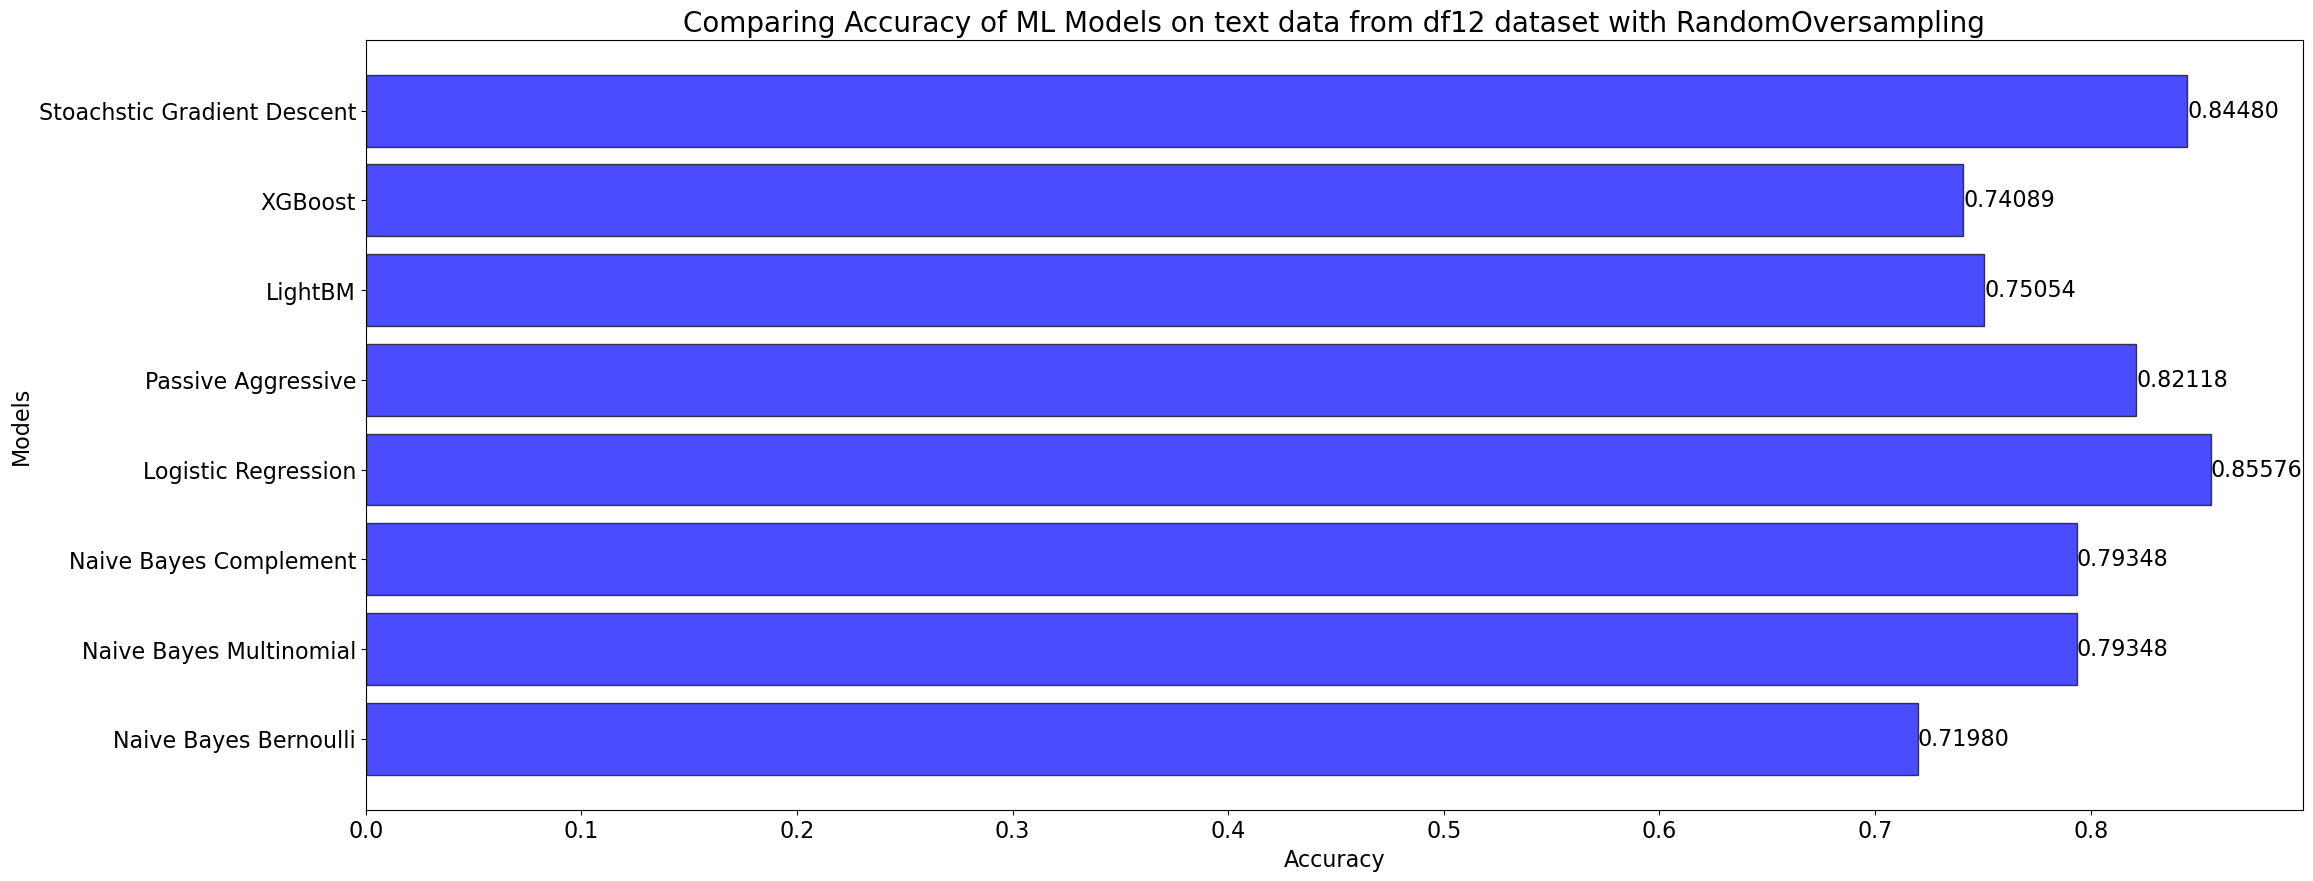

In [219]:
# Data for the chart
acc_labels_sel = list(acc_labels_df12_tfidf_sel.keys())
acc_values_sel = list(acc_labels_df12_tfidf_sel.values())
# colors=['yellow','orange','magenta', 'gray', 'blue', 'black', 'white', 'lightgreen', 'darkred', 'purple']

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing Accuracy of ML Models on text data from df12 dataset with RandomOversampling', fontsize=20)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(acc_labels_sel, acc_values_sel, color='blue', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(acc_values_sel):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();

## PLOT 2: Accuracy of all models

In [211]:
#Creating the Dictionary with model name as key and accuracy as key-value
acc_labels_df12_tfidf_all={'Naive Bayes Bernoulli':accuracy_NB_Bern_df12_tfidf,
        'Naive Bayes Multinomial':accuracy_NB_Mult_df12_tfidf,
        'Naive Bayes Complement':accuracy_NB_Compl_df12_tfidf,
        'Logistic Regression':accuracy_LogReg_df12_tfidf,
        'Logistic Regression with class weight':accuracy_LogReg_df12_tfidf_CW,
#        'Random Forest':accuracy_rf_df12_tfidf,
        'Passive Aggressive':accuracy_PassAgg_df12_tfidf,
        'Passive Aggressive with class weight':accuracy_PassAgg_df12_tfidf_CW,
        'LightBM 20 rounds':accuracy_LightGBM_df12_tfidf,
        'LightBM 200 rounds':accuracy_LightGBM_df12_tfidf_200,
        'LightBM 500 rounds':accuracy_LightGBM_df12_tfidf_500,
#        'LightBM 500 rounds with class weight':accuracy_LightGBM_df12_tfidf_500_CW,
#        'CatBoost 20 rounds':accuracy_CatBoost_df12_tfidf, 
 #       'CatBoost 50 rounds':accuracy_CatBoost_df12_tfidf_50, 
        'XGBoost 50 rounds':accuracy_XGBoost_df12_tfidf,
        'XGBoost 200 rounds':accuracy_XGBoost_df12_tfidf_200,
        'XGBoost 500 rounds':accuracy_XGBoost_df12_tfidf_500,
        'Stoachstic Gradient Descent':accuracy_sgd_df12_tfidf,
        'Stoachstic Gradient Descent with class weight':accuracy_sgd_df12_tfidf_CW} 
        


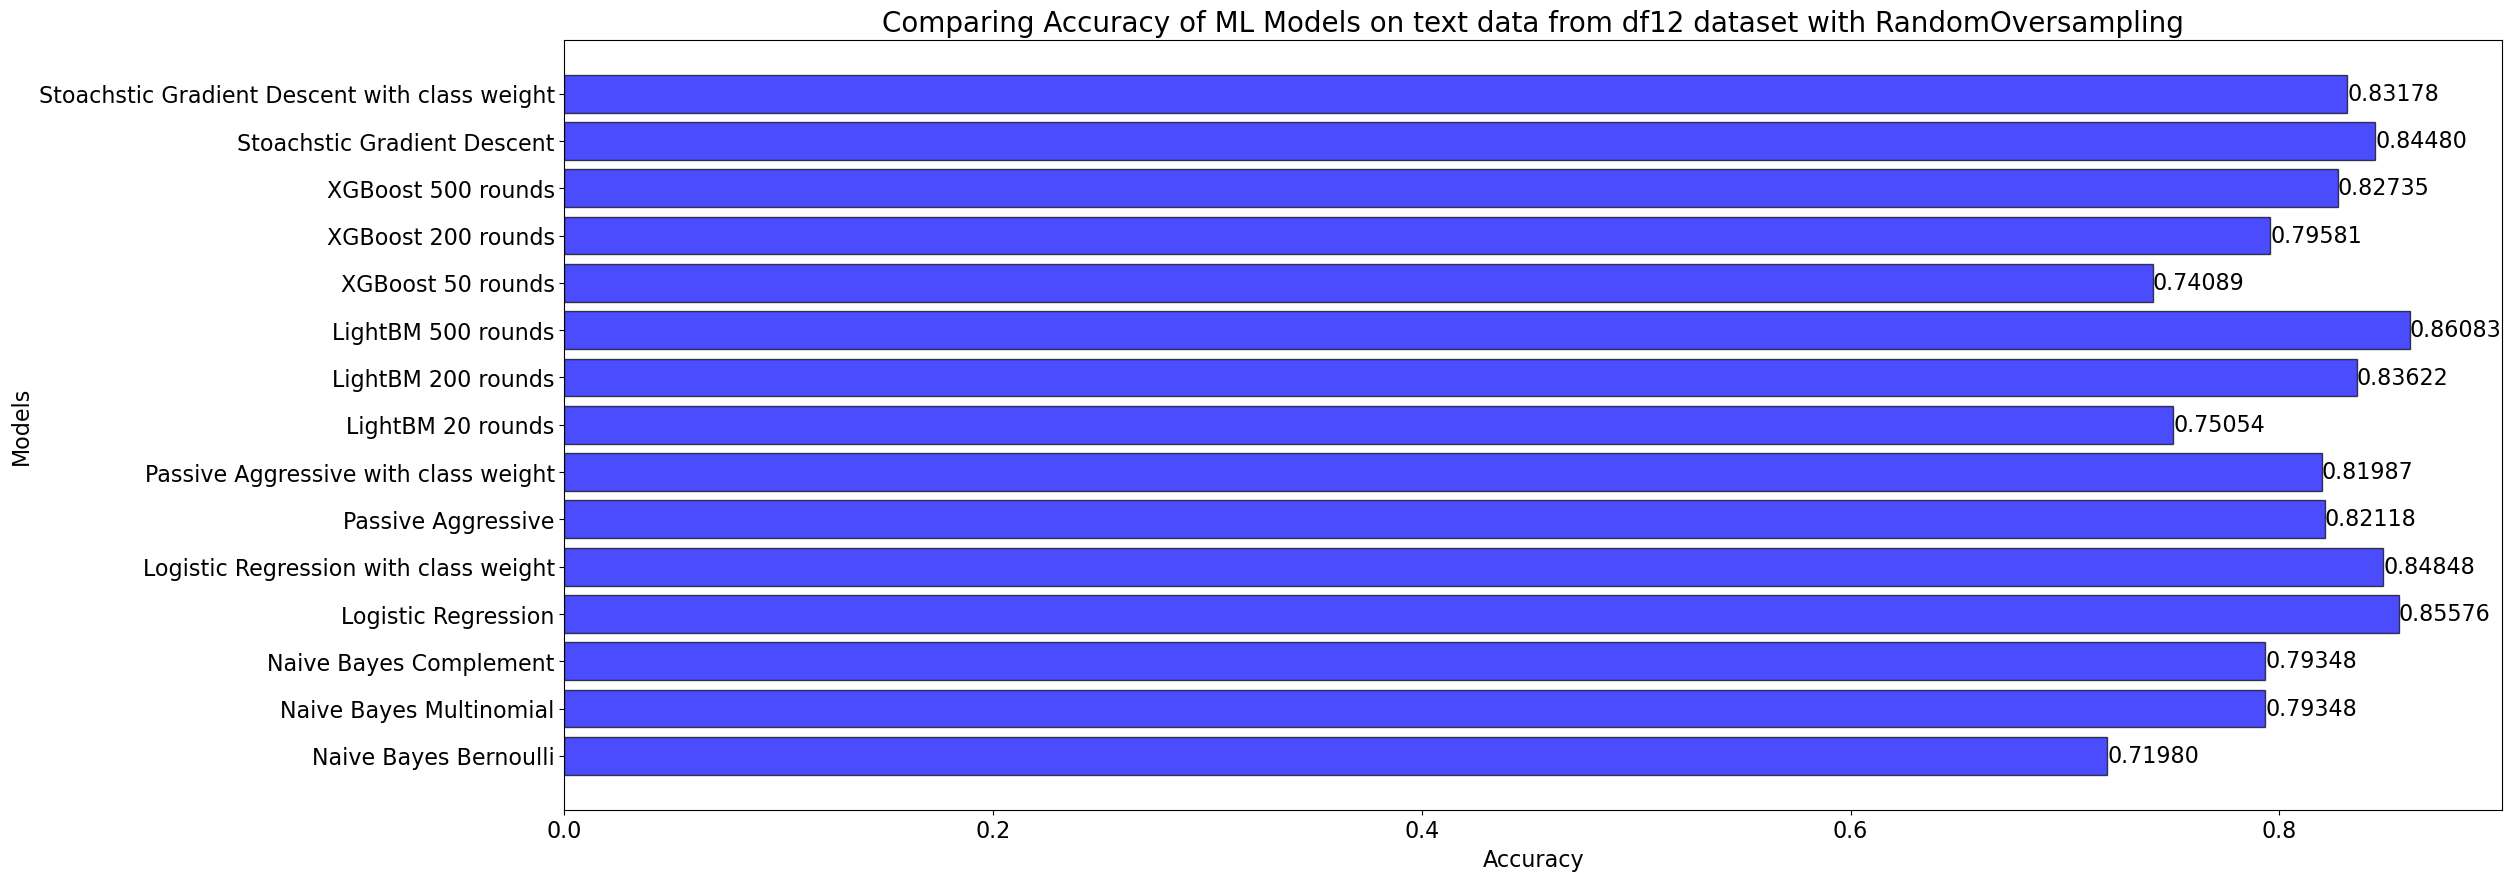

In [220]:
# Data for the chart
acc_labels_all = list(acc_labels_df12_tfidf_all.keys())
acc_values_all = list(acc_labels_df12_tfidf_all.values())
# colors=['yellow','orange','magenta', 'gray', 'lightgray', 'blue', 'black', 'darkgray', 'white', 'lightgreen', 'darkred', 'purple']

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing Accuracy of ML Models on text data from df12 dataset with RandomOversampling', fontsize=20)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(acc_labels_all, acc_values_all, color='blue', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(acc_values_all):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();

## PLOT 3: f1 score of selected models

In [214]:
#Creating the Dictionary with model name as key and accuracy as key-value
f1_labels_df12_tfidf_sel={'Naive Bayes Bernoulli':f1_NB_Bern_df12_tfidf,
        'Naive Bayes Multinomial':f1_NB_Mult_df12_tfidf,
        'Naive Bayes Complement':f1_NB_Compl_df12_tfidf,
        'Logistic Regression':f1_LogReg_df12_tfidf,
#        'Random Forest':f1_rf_df12_tfidf,
        'Passive Aggressive':f1_PassAgg_df12_tfidf,
        'LightBM':f1_LightGBM_df12_tfidf,
 #       'CatBoost':f1_CatBoost_df12_tfidf, 
        'XGBoost':f1_XGBoost_df12_tfidf,
        'Stoachstic Gradient Descent':f1_sgd_df12_tfidf} 
        


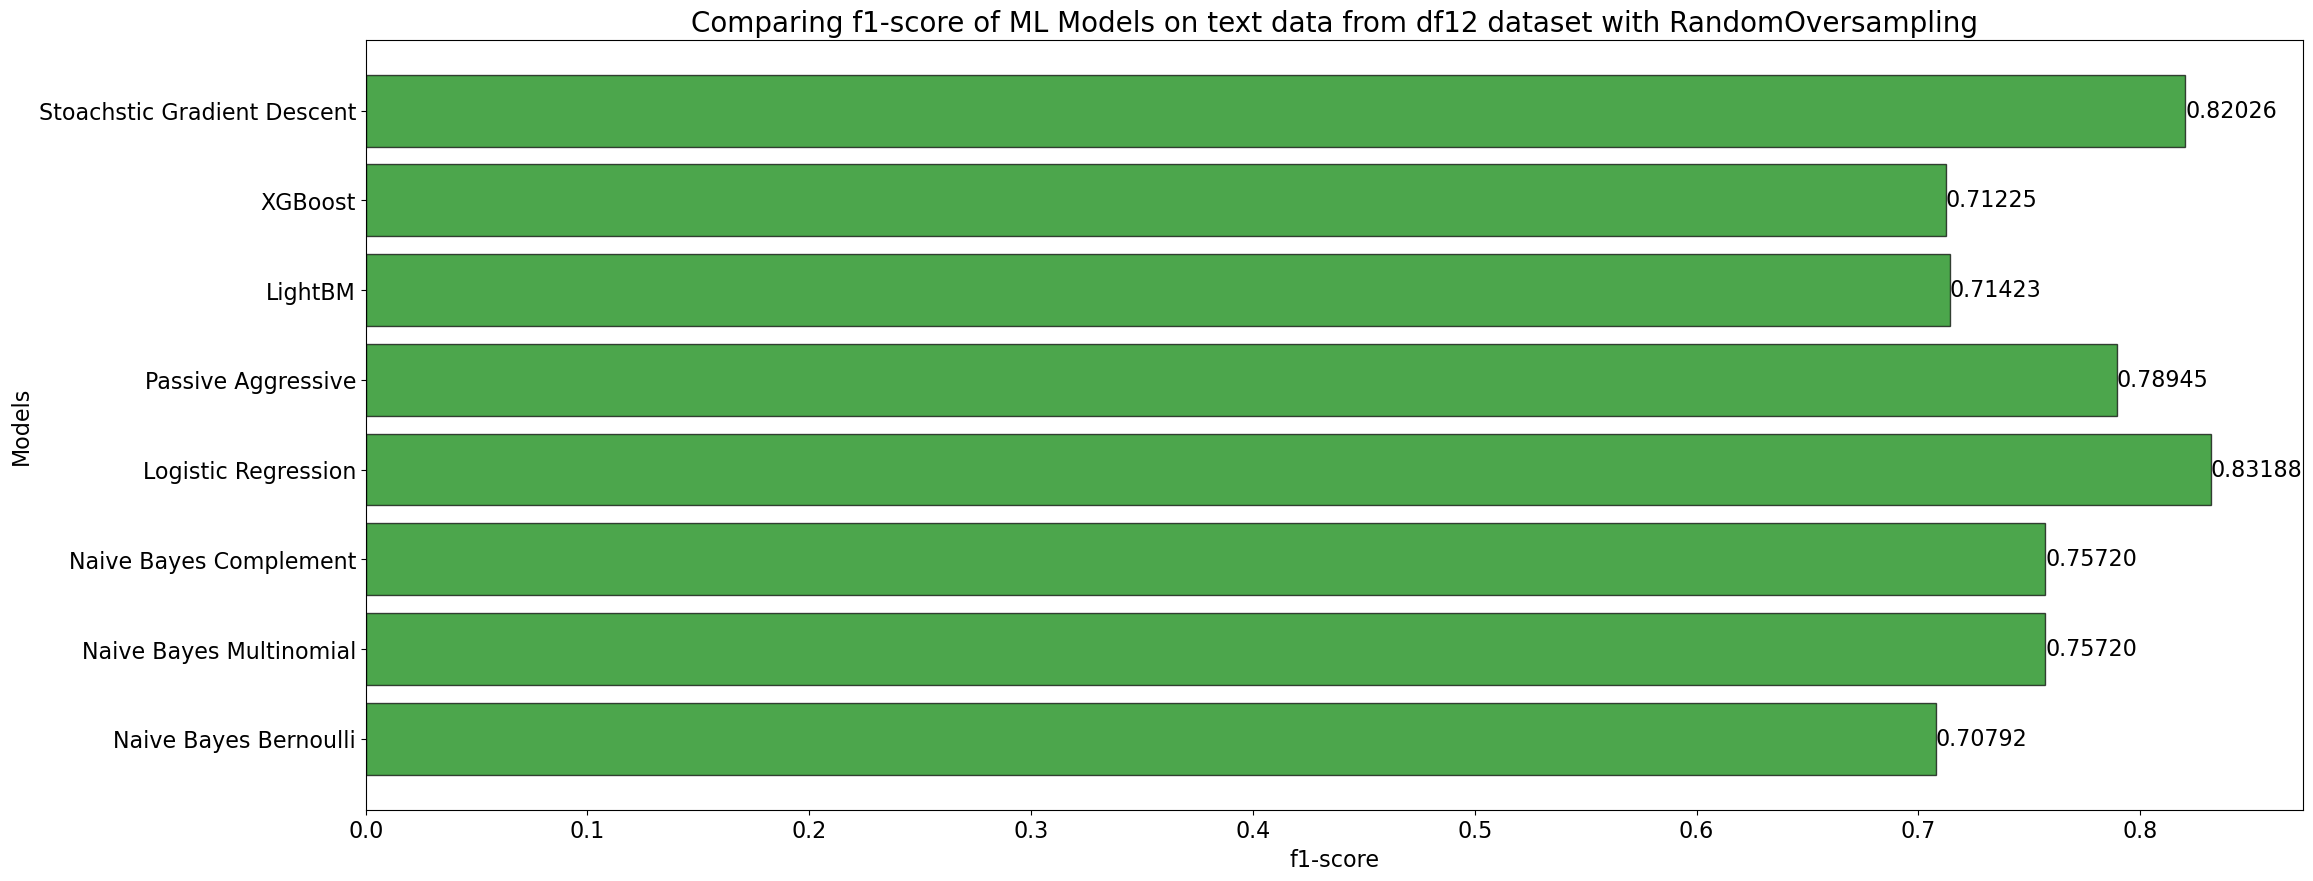

In [221]:
# Data for the chart
f1_labels_sel = list(f1_labels_df12_tfidf_sel.keys())
f1_values_sel = list(f1_labels_df12_tfidf_sel.values())
# colors=['yellow','orange','magenta', 'gray', 'blue', 'black', 'white', 'lightgreen', 'darkred', 'purple']

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing f1-score of ML Models on text data from df12 dataset with RandomOversampling', fontsize=20)
plt.xlabel('f1-score', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(f1_labels_sel, f1_values_sel, color='green', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(f1_values_sel):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();

## PLOT 4: f1 score of all models

In [217]:
#Creating the Dictionary with model name as key and accuracy as key-value
f1_labels_df12_tfidf_all={'Naive Bayes Bernoulli':f1_NB_Bern_df12_tfidf,
        'Naive Bayes Multinomial':f1_NB_Mult_df12_tfidf,
        'Naive Bayes Complement':f1_NB_Compl_df12_tfidf,
        'Logistic Regression':f1_LogReg_df12_tfidf,
        'Logistic Regression with class weight':f1_LogReg_df12_tfidf_CW,
#        'Random Forest':f1_rf_df12_tfidf,
        'Passive Aggressive':f1_PassAgg_df12_tfidf,
        'Passive Aggressive with class weight':f1_PassAgg_df12_tfidf_CW,
        'LightBM 20 rounds':f1_LightGBM_df12_tfidf,
        'LightBM 200 rounds':f1_LightGBM_df12_tfidf_200,
        'LightBM 500 rounds':f1_LightGBM_df12_tfidf_500,
#        'LightBM 500 rounds with class weight':f1_LightGBM_df12_tfidf_500_CW,
#        'CatBoost 20 rounds':f1_CatBoost_df12_tfidf, 
#        'CatBoost 50 rounds':f1_CatBoost_df12_tfidf_50, 
        'XGBoost 50 rounds':f1_XGBoost_df12_tfidf,
        'XGBoost 200 rounds':f1_XGBoost_df12_tfidf_200,
        'XGBoost 500 rounds':f1_XGBoost_df12_tfidf_500,
        'Stoachstic Gradient Descent':f1_sgd_df12_tfidf,
        'Stoachstic Gradient Descent with class weight':f1_sgd_df12_tfidf_CW} 
        

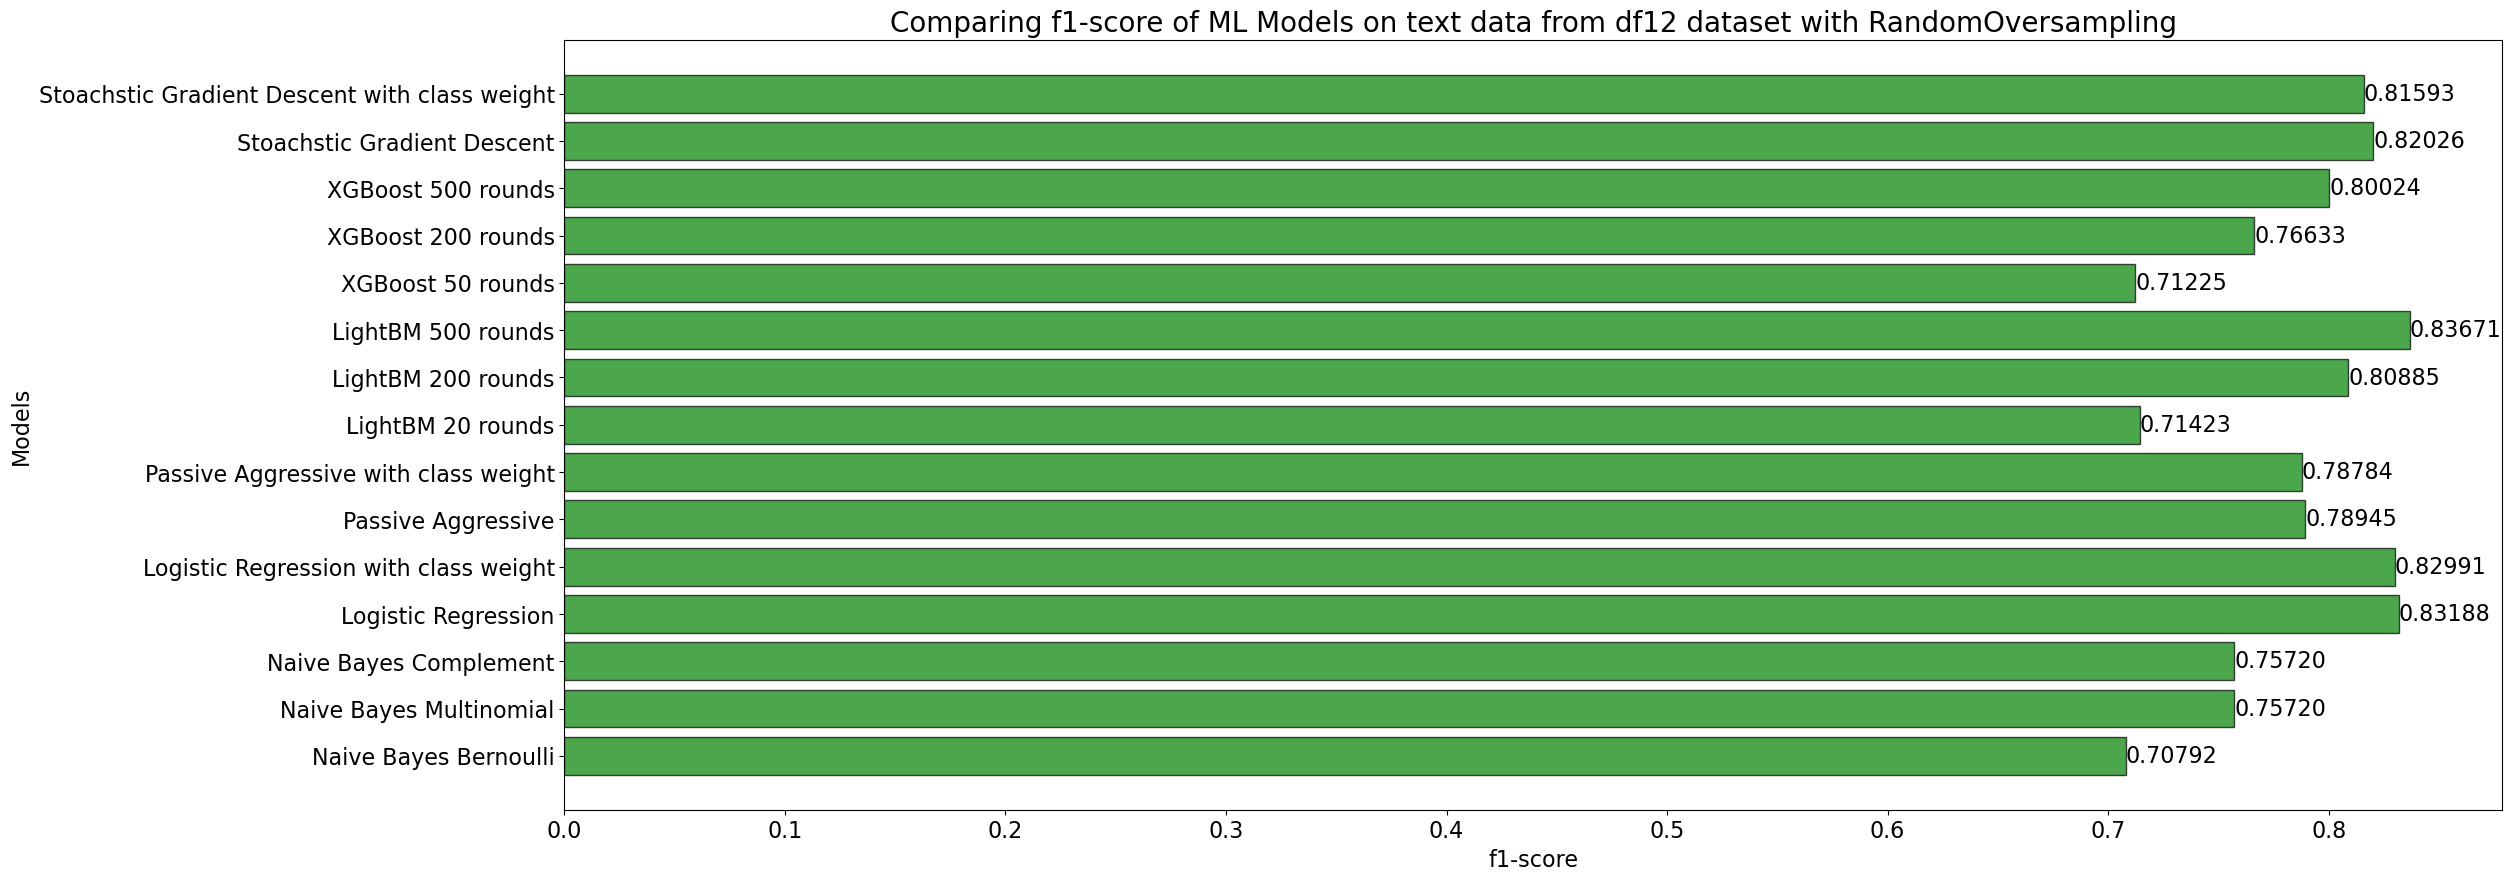

In [222]:
# Data for the chart
f1_labels_all = list(f1_labels_df12_tfidf_all.keys())
f1_values_all = list(f1_labels_df12_tfidf_all.values())
# colors=['yellow','orange','magenta', 'gray', 'lightgray', 'blue', 'black', 'darkgray', 'white', 'lightgreen', 'darkred', 'purple']

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing f1-score of ML Models on text data from df12 dataset with RandomOversampling', fontsize=20)
plt.xlabel('f1-score', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(f1_labels_all, f1_values_all, color='green', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(f1_values_all):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();